In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import netCDF4 as ncdf
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import glob as glob
import os as os
import sys as sys
#from file_tools import *
import pygrib

In [29]:
# Special thanks to Scott Ellis of DOE for sharing codes for reading grib2

def grbFile_attr(grb_file, type=None):

    dataloc = np.array(grb_file[1].latlons())

    return dataloc[0], dataloc[1]

def grbVar_to_slice(grb_obj, type=None):

    """Takes a single grb object for a variable returns a 2D plane"""

    return {'data' : grb_obj[0].values, 'units' : grb_obj[0]['units'],
            'date' : grb_obj[0].date, 'fcstStart' : grb_obj[0].time, 'fcstTime' : grb_obj[0].step}

def grbVar_to_cube(grb_obj, type='isobaricInhPa'):

    """Takes a single grb object for a variable containing multiple
    levels. Can sort on type. Compiles to a cube"""

    all_levels = np.array([grb_element['level'] for grb_element in grb_obj])
    types      = np.array([grb_element['typeOfLevel'] for grb_element in grb_obj])

    if type != None:
        levels = []
        for n, its_type in enumerate(types):
            if type == types[n]:
                levels.append(all_levels[n])
        levels = np.asarray(levels)
    else:
        levels = all_levels
        
    n_levels   = len(levels)
    indexes    = np.argsort(levels)[::-1] # highest pressure first
    cube       = np.zeros([n_levels, grb_obj[0].values.shape[0], grb_obj[1].values.shape[1]])

    for k in range(n_levels):
        cube[k,:,:] = grb_obj[indexes[k]].values

    return {'data' : cube, 'units' : grb_obj[0]['units'], 'levels' : levels[indexes],
            'date' : grb_obj[0].date, 'fcstStart' : grb_obj[0].time, 'fcstTime' : grb_obj[0].step}

# Stuff to convert file to netCDF

In [80]:
file = '/Users/Louis.Wicker/CAM_Case_Studies/20210526/HRRR/hrrr.20210526_conus_hrrr.t00z.wrfnatf23.grib2'

#var_list = ['UH']
var_list = ['']

default = {            #  Grib2 name                 / No. of Dims /  Type
           'TEMP':     ['Temperature',                           3, 'hybrid'],
           'PRES':     ['Pressure',                              3, 'hybrid'],
           'SFC_HGT':  ['Orography',                             2, 'hybrid'],
           'HGT':      ['Geopotential Height',                   3, 'hybrid'],              
           'W':        ['Vertical velocity',                     3, 'hybrid'],
           'U':        ['U component of wind',                   3, 'hybrid'],
           'V':        ['V component of wind',                   3, 'hybrid'],
           'UH':       [1018,                                    2, 'hybrid'],
           'CREF':     [1008,                                    2, 'hybrid'],
           }

if var_list != ['']:
    variables = {k: default[k] for k in default.keys() & set(var_list)}  # yea, I stole this....
else:
    variables = default

print(f'-'*120,'\n')
print(f'HRRR_Extract: Extracting variables from grib file: {file}','\n')

# open file

grb_file = pygrib.open(file)

# Get lat lons

lats, lons = grbFile_attr(grb_file)

pres = None

for n, key in enumerate(variables):
    
    print('Reading my variable: ',key, 'from GRIB file variable: ',variables[key][0])
    
    if type(variables[key][0]) == type('1'):
        grb_var = grb_file.select(name=variables[key][0])
    else:
        grb_var = [grb_file.message(variables[key][0])]
        
    if variables[key][1] == 3:
        
        cube = grbVar_to_cube(grb_var, type=variables[key][2])
        pres = cube['levels']

        new = xr.DataArray( cube['data'], dims = ['nz','ny','nx'], 
                                          coords={"lats": (["ny","nx"], lats),
                                                 "lons": (["ny","nx"], lons), 
                                                 "pres": (["nz"],      pres) } )
        date      = cube['date'] 
        fcstStart = cube['fcstStart']
        fcstHour  = cube['fcstTime']
           
    if variables[key][1] == 2:
        
        cube = grbVar_to_slice(grb_var, type=variables[key][2])
        
        new = xr.DataArray( cube['data'], dims=['ny','nx'], 
                                         coords={"lats": (["ny","nx"], lats),
                                                 "lons": (["ny","nx"], lons) } )  
        date      = cube['date'] 
        fcstStart = cube['fcstStart']

    if n == 0:
            
        ds_conus = new.to_dataset(name = key)
    
    else:         
 
        ds_conus[key] = new
    
    del(new)
    
print(ds_conus)
print(date, fcstStart, fcstHour)
    
writeout = True
prefix   = None
    
if writeout:
    dir, base = os.path.split(file)
    if prefix == None:  
        outfilename = os.path.join(dir, 'hrrr_%8.8i%2.2i_F%2.2i.nc' % (date,fcstStart,fcstHour))
        ds_conus.to_netcdf(outfilename, mode='w')  
        print(f'Successfully wrote new data to file:: {outfilename}','\n')
        # return ds_conus, outfilename
            
grb_file.close()


------------------------------------------------------------------------------------------------------------------------ 

HRRR_Extract: Extracting variables from grib file: /Users/Louis.Wicker/CAM_Case_Studies/20210526/HRRR/hrrr.20210526_conus_hrrr.t00z.wrfnatf23.grib2 

Reading my variable:  TEMP from GRIB file variable:  Temperature
Reading my variable:  PRES from GRIB file variable:  Pressure
Reading my variable:  SFC_HGT from GRIB file variable:  Orography
Reading my variable:  HGT from GRIB file variable:  Geopotential Height
Reading my variable:  W from GRIB file variable:  Vertical velocity
Reading my variable:  U from GRIB file variable:  U component of wind
Reading my variable:  V from GRIB file variable:  V component of wind
Reading my variable:  UH from GRIB file variable:  1018
1018:199:199 (max):lambert:heightAboveGroundLayer:levels 5000-2000 m:fcst time 22-23 hrs (max):from 202105260000
Reading my variable:  CREF from GRIB file variable:  1008
1008:Derived radar reflecti

In [11]:
file = '/Users/Louis.Wicker/CAM_Case_Studies/20210526/RRFS/nord3/PRSLEV.GrbF06'

var_list = ['CREF']

default = {               #grib name               #dimensions
           'TEMP':     ['Temperature',                 3],
           'SFC_HGT':  ['Orography',                   2],
           'HGT':      ['Geopotential Height',         3],              
           'W':        ['Geometric vertical velocity', 3],
           'U':        ['U component of wind',         3],
           'V':        ['V component of wind',         3],
           'UH':       ['Updraft Helicity',            2],
           'CREF':     ['Derived radar reflectivity',  3],
           }

if var_list != ['']:
    variables = {k: default[k] for k in default.keys() & set(var_list)}  # yea, I stole this....
else:
    variables = default

print(f'-'*120,'\n')
print(f'FV3_Extract: Extracting variables from grib file: {file}','\n')

# open file

grb_file = pygrib.open(file)

# Get lat lons

lats, lons   = grbFile_attr(grb_file)

pres = None

for n, key in enumerate(variables):
    
    print('Reading my variable: ',key, 'from GRIB file variable: ',variables[key][0])
    
    grb_var = grb_file.select(name=variables[key][0])
    
    if variables[key][1] == 3:
        
        if key == 'CREF':  # this is a painful hack because of grib weirdness
            cube = grbVar_to_cube(grb_var, type=None)
            print(cube['data'].shape)
            new = xr.DataArray( cube['data'].max(axis=0), dims=['ny','nx'], 
                                coords={"lats": (["ny","nx"], lats),
                                        "lons": (["ny","nx"], lons) } )
        else:
            cube = grbVar_to_cube(grb_var, type='hybrid')
            pres = cube['levels']

            new = xr.DataArray( cube['data'],dims=['nz','ny','nx'], 
                                             coords={"lats": (["ny","nx"], lats),
                                                     "lons": (["ny","nx"], lons), 
                                                     "pres": (["nz"],      pres) } )
    if variables[key][1] == 2:
        cube = grbVar_to_slice(grb_var)
        new = xr.DataArray( cube['data'], dims=['ny','nx'], 
                                         coords={"lats": (["ny","nx"], lats),
                                                 "lons": (["ny","nx"], lons) } )

    if n == 0:
            
        ds_conus = new.to_dataset(name = key)
    
    else:         
 
        ds_conus[key] = new
    
    del(new)
    
print(ds_conus)
    
writeout = True
prefix   = None
    
if writeout:
    dir, base = os.path.split(file)
    if prefix == None:  
        outfilename = os.path.join(dir, 'conus_%s.nc' % (base[-3:]))
        ds_conus.to_netcdf(outfilename, mode='w')  
        print(f'Successfully wrote new data to file:: {outfilename}','\n')
        # return ds_conus, outfilename
            
grb_file.close()

------------------------------------------------------------------------------------------------------------------------ 

FV3_Extract: Extracting variables from grib file: /Users/Louis.Wicker/CAM_Case_Studies/20210526/RRFS/nord3/PRSLEV.GrbF06 

Reading my variable:  CREF from GRIB file variable:  Derived radar reflectivity
(5, 1014, 1746)
<xarray.Dataset>
Dimensions:  (ny: 1014, nx: 1746)
Coordinates:
    lats     (ny, nx) float64 21.89 21.89 21.9 21.91 ... 47.59 47.58 47.57 47.56
    lons     (ny, nx) float64 -122.2 -122.1 -122.1 ... -62.29 -62.26 -62.22
Dimensions without coordinates: ny, nx
Data variables:
    CREF     (ny, nx) float64 -20.0 -20.0 -20.0 -20.0 ... -20.0 -20.0 -20.0
Successfully wrote new data to file:: /Users/Louis.Wicker/CAM_Case_Studies/20210526/RRFS/nord3/conus_F06.nc 



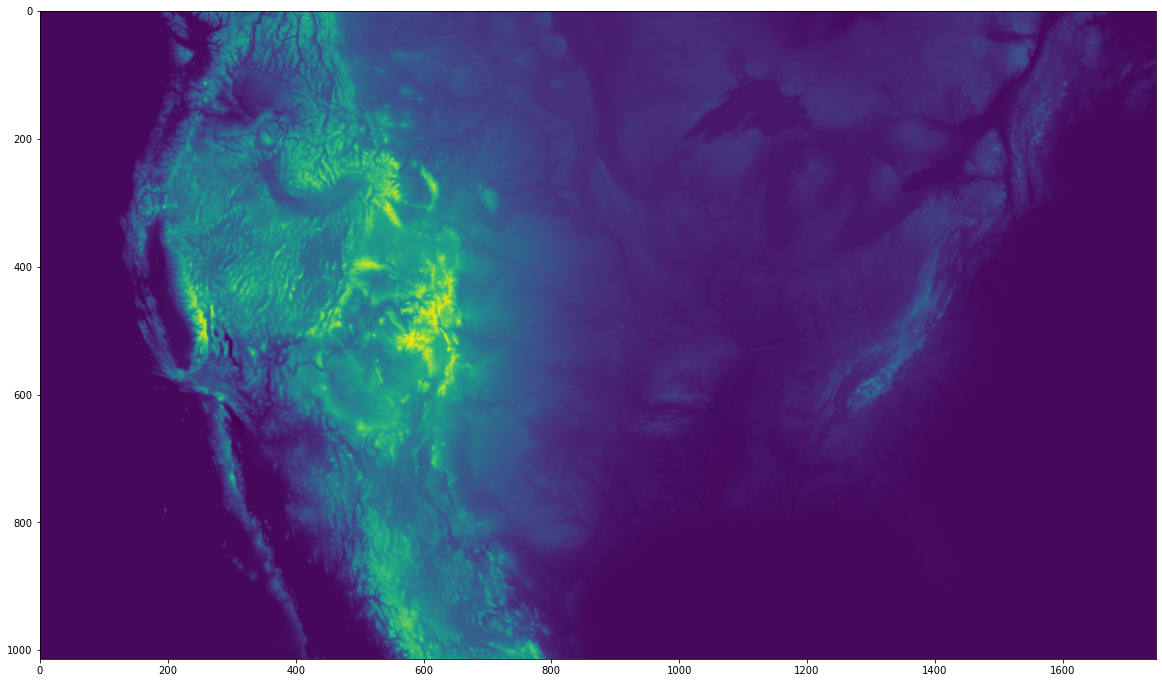

In [13]:

fig = plt.subplots(figsize = (20,20))
plt.imshow(ds_conus['SFC_HGT'][::-1,:])


In [60]:
file = '/Users/Louis.Wicker/CAM_Case_Studies/20210526/HRRR/hrrr.20210526_conus_hrrr.t00z.wrfnatf18.grib2'
gr = pygrib.open(file)

gr.*?


gr.__call__
gr.__class__
gr.__delattr__
gr.__dir__
gr.__doc__
gr.__enter__
gr.__eq__
gr.__exit__
gr.__format__
gr.__ge__
gr.__getattribute__
gr.__getitem__
gr.__gt__
gr.__hash__
gr.__init__
gr.__init_subclass__
gr.__iter__
gr.__le__
gr.__lt__
gr.__ne__
gr.__new__
gr.__next__
gr.__reduce__
gr.__reduce_ex__
gr.__repr__
gr.__setattr__
gr.__setstate__
gr.__sizeof__
gr.__str__
gr.__subclasshook__
gr.close
gr.closed
gr.has_multi_field_msgs
gr.message
gr.messagenumber
gr.messages
gr.name
gr.read
gr.readline
gr.rewind
gr.seek
gr.select
gr.tell

In [76]:
# for n, g in enumerate(gr):
#     print(n, g

a = gr.message(1003)
a.date

20210526

In [37]:
for gr in g:
    print(gr)

1:Pressure:Pa (instant):lambert:hybrid:level 1:fcst time 18 hrs:from 202105260000
2:Cloud mixing ratio:kg kg**-1 (instant):lambert:hybrid:level 1:fcst time 18 hrs:from 202105260000
3:82:82 (instant):lambert:hybrid:level 1:fcst time 18 hrs:from 202105260000
4:Rain mixing ratio:kg kg**-1 (instant):lambert:hybrid:level 1:fcst time 18 hrs:from 202105260000
5:Snow mixing ratio:kg kg**-1 (instant):lambert:hybrid:level 1:fcst time 18 hrs:from 202105260000
6:Graupel (snow pellets):kg kg**-1 (instant):lambert:hybrid:level 1:fcst time 18 hrs:from 202105260000
7:28:28 (instant):lambert:hybrid:level 1:fcst time 18 hrs:from 202105260000
8:29:29 (instant):lambert:hybrid:level 1:fcst time 18 hrs:from 202105260000
9:100:100 (instant):lambert:hybrid:level 1:fcst time 18 hrs:from 202105260000
10:Particulate matter (fine):(10**-6 g) m**-3 (instant):lambert:hybrid:level 1:fcst time 18 hrs:from 202105260000
11:Particulate matter (coarse):(10**-6 g) m**-3 (instant):lambert:hybrid:level 1:fcst time 18 hrs:fr